# Yeah, this one does not work yet. Or will not ever.

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)

C:\Users\kicjo\Desktop\my-anns\sinus_recurrent_not_time_series


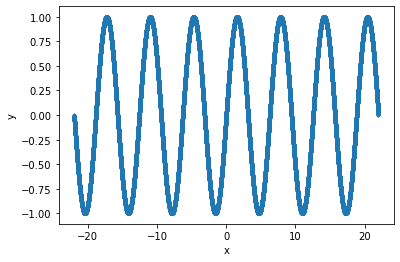

In [2]:
data_length = 100000
noise = np.random.normal(0.01, 0.3, data_length)
x = np.linspace(-7 * np.pi, 7 * np.pi, data_length)
y = np.sin(x)  # + noise
df = pd.DataFrame(data={'X': x, 'y': y})

plt.scatter(df["X"], df["y"], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)


In [3]:
n_steps = 1
n_inputs = 1
n_neurons = 150
n_outputs = 1
n_layers = 3

learning_rate = 0.001


In [4]:
X_train_o = X_train_o.reshape(-1,n_steps,n_inputs)
X_test_o = X_test_o.reshape(-1,n_steps,n_inputs)
X_val_o = X_val_o.reshape(-1,n_steps,n_inputs)
y_train_o = y_train_o.reshape(-1, 1)
y_test_o = y_test_o.reshape(-1, 1)
y_val_o = y_val_o.reshape(-1, 1)

In [5]:
X_train_o.shape

(64000, 1, 1)

In [6]:
data_length = 500000
x_long = np.linspace(-20 * np.pi, 20 * np.pi, data_length)
y_long = np.sin(x_long) 

X_train_long = x_long.reshape(-1, n_steps, n_outputs)
y_train_long =y_long.reshape(-1, 1)

In [7]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None,n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

top_layer_h_state = states[-1][1]
y_pred = tf.layers.dense(top_layer_h_state, n_outputs)
error = y_pred - y

mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

W0806 20:43:22.188970 13940 deprecation.py:323] From <ipython-input-7-88c6d1e51ec4>:7: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0806 20:43:22.190963 13940 deprecation.py:323] From <ipython-input-7-88c6d1e51ec4>:8: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
W0806 20:43:22.191961 13940 deprecation.py:323] From <ipython-input-7-88c6d1e51ec4>:9: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0806 20:43:22.631785 13940 deprecati

In [8]:
n_epochs = 10
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_o, y_train_o, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
        mse_test = mse.eval(feed_dict={X: X_test_o, y: y_test_o})
        print(epoch, "Last batch mse:", mse_batch, "Test mse:", mse_test)
    predictions_long = y_pred.eval(feed_dict={X: X_train_long, y: y_train_long})
    long_mse_test = mse.eval(feed_dict={X: X_train_long, y: y_train_long})
    print(epoch, "Long Test mse:", long_mse_test)
    

0 Last batch mse: 0.45058006 Test mse: 0.46538815
1 Last batch mse: 0.5011128 Test mse: 0.43910536
2 Last batch mse: 0.0017450232 Test mse: 0.0018224663
3 Last batch mse: 0.00017428499 Test mse: 0.00020763867
4 Last batch mse: 0.00016104103 Test mse: 0.00022301642
5 Last batch mse: 0.00015467613 Test mse: 0.00014502696
6 Last batch mse: 0.00018324684 Test mse: 0.00016755436
7 Last batch mse: 0.00021999449 Test mse: 0.00021832189
8 Last batch mse: 0.00010747257 Test mse: 0.00010641253
9 Last batch mse: 0.00014717609 Test mse: 0.00016817507
9 Long Test mse: 2.9696155


In [9]:
print(X_train_long.shape)
print(predictions_long.shape)
print(X_train_long.reshape(-1,1).shape)

(500000, 1, 1)
(500000, 1)
(500000, 1)


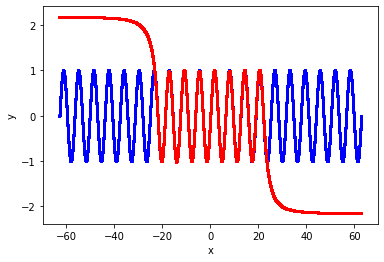

In [10]:
plt.scatter(x_long,y_long,s=5, color='b',marker='.')
plt.scatter(X_train_long.reshape(-1,1), predictions_long,s=7, color='r',marker = ',')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()